<a href="https://colab.research.google.com/github/karasu1982/POS_Data_Analytics/blob/main/notebook/%E6%99%82%E7%B3%BB%E5%88%97%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 時系列分析

時系列分析は、その名の通りデータを時系列での推移をみていく分析です。

売上や株価など、時間軸で変わっていくものの変化を確認するために用いられます。さらに、それらの変化に法則性を見つけ出し、将来の予測をするといった「時系列予測」にも使われます。

ただし、今回はあくまで時系列の推移を確認するところまででとどめておきます。

## 環境設定

In [ ]:
%%bash
pip install duckdb-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.1 MB/s eta 0:00:00


In [ ]:
# 標準ライブラリ
import pandas as pd
import numpy as np

# データ見える化
import seaborn as sns
import matplotlib.pyplot as plt

# DuckDB
import duckdb

## データ準備

ID-POSのサンプルデータとして、下記を利用

https://www.kyoritsu-pub.co.jp/book/b10003634.html

In [ ]:
%%bash
wget https://kyoritsu-pub.sakura.ne.jp/app/file/goods_contents/2319.zip
unzip /content/2319.zip
unzip /content/DataProcess.20151001/src/data/Tafeng/Tafeng.zip

In [ ]:
df = pd.read_csv("/content/Tafeng_dataset/Tafeng.csv")

# データ型を
df = df.astype({'CustID': 'object', 'ProductSubClass': 'object', 'ProductID': 'object'})

In [ ]:
df.head(3)

,Time,CustID,Age,Area,ProductSubClass,ProductID,Amount,Asset,SalesPrice
0,2000-11-01 00:00:00,46855,D,E,110411,4710085120468,3,51,57
1,2000-11-01 00:00:00,539166,E,E,130315,4714981010038,2,56,48
2,2000-11-01 00:00:00,663373,F,E,110217,4710265847666,1,180,135


## データ集計

時系列で測定する単位を、日次や月次、四半期ごと・年次など、データの種類によってどの単位でみていくかを気を付けなければなりません。


一般に購買データでは、時系列の単位が細かい順番に、次の３種類が使われます。
* 日次：基本となる単位の１つ。ただし、〇曜日は安売りデーのような曜日ファクターの影響が強く、日次での〇日前との比較があまり意味をなさないケースがある

* 週次：日次の曜日ファクターをのぞけるので、小売りの現場では最も重宝される単位。スーパーなどでは、52週MDとして年間の商品計画を立て、その状況を週次の時系列分析として確認するなどに使われる

* 月次：対外的な発表では多くの場面で月次での時系列が使われる。とはいえ、月ごとの日数の違いや、曜日の違い（休日が多い・少ないなど）もあるため、単純な比較では意味がないケースが多い


また、時系列ではなく比較の分析になるが、時間軸として次の単位で比較することが多い。

* 時間帯ごと：朝はシニアが、昼～夕方は主婦が、夕方以降は勤め人が多いといった比較や、その層に受ける商品の分析を行う。

* 曜日ごと：〇曜日は安売りデーの時に、どの程度売上が伸びるのかといった分析を行う。




In [ ]:
import duckdb

# SQLに慣れている方にとっては、少々くどいかもしれませんが、可読性を高めるために、処理を１つ１つ分解してWITH句で実行しています。
#
# 私がBigQueryの文法に慣れていることもあり、次の3点で修正が必要でした。他にも微妙な差はありそうなので、都度都度直す必要がありますね。
# ・コメントアウトは#は使わず、-- で行う
# ・文字列はダブルコーテーション（ " )ではなく、シングルクオーテーション（ ' )でくくる
# ・日付項目は、文字列を自動で日付型化しないため、DATETIME '2000-11-01'のように日付型を明示的に指定する

# まずは日次で集計してみましょう

df_daily_output = duckdb.query(
    f"""
    SELECT
      CAST(Time AS DATE) AS YearMonthDate,
      COUNT(DISTINCT CustID) AS Num_of_Purchaser,
      SUM(Amount) AS Total_of_Amount,
      SUM(Amount * SalesPrice) AS Total_of_Sales
    FROM df
    GROUP BY YearMonthDate
    ORDER BY YearMonthDate
    """
).to_df()

作成したテーブルのアウトプット
*   YearMonthDate：購入日。ここでは日次で比較
*   Num_of_Purchaser：総購入者数
*   Total_of_Amount：総購入個数
*   Total_of_Sales：総売上高

日付順にソートしています。

In [ ]:
 # データ確認
df_daily_output.head(100)

,YearMonthDate,Num_of_Purchaser,Total_of_Amount,Total_of_Sales
0,2000-11-01,193,1701.0,175614.0
1,2000-11-02,1029,11101.0,4179104.0
2,2000-11-03,1089,11285.0,6183338.0
3,2000-11-04,1221,13359.0,2265290.0
4,2000-11-05,1583,18846.0,2937008.0
...,...,...,...,...
95,2001-02-04,1490,16196.0,2635240.0
96,2001-02-05,955,7789.0,1148398.0
97,2001-02-06,970,8197.0,1306649.0
98,2001-02-07,849,6955.0,1151672.0


In [ ]:
# 続いて週次で集計してみましょう

df_weekly_output = duckdb.query(
    f"""
    SELECT
    -- 週を出すために、DATE_TRUNC関数を利用
    -- DATE_TRUNC(date_part, date_expression)という文法ですが、BigQueryのDATE_TRUNC(date_expression, date_part)の逆なのが、少々戸惑いました
    -- https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions#date_trunc
    -- date_part : 'DAY', 'WEEK', 'MONTH'などの集計基準、date_expression：日付型の変数

      DATE_TRUNC('WEEK', CAST(Time AS DATE)) AS YearMonthWeek,
      COUNT(DISTINCT CustID) AS Num_of_Purchaser,
      SUM(Amount) AS Total_of_Amount,
      SUM(Amount * SalesPrice) AS Total_of_Sales
    FROM df
    GROUP BY YearMonthWeek
    ORDER BY YearMonthWeek
    """
).to_df()

In [ ]:
 # データ確認
df_weekly_output.head(100)

,YearMonthWeek,Num_of_Purchaser,Total_of_Amount,Total_of_Sales
0,2000-10-30,4329,56292.0,15740354.0
1,2000-11-06,6504,74758.0,12310179.0
2,2000-11-13,5361,58363.0,13874600.0
3,2000-11-20,6853,85443.0,44742460.0
4,2000-11-27,6262,74696.0,49390360.0
5,2000-12-04,5965,69734.0,63424834.0
6,2000-12-11,6662,72364.0,19296902.0
7,2000-12-18,1525,14104.0,10425507.0
8,2000-12-25,5385,55688.0,64876845.0
9,2001-01-01,3866,38498.0,12148401.0


<Axes: xlabel='YearMonthWeek', ylabel='Total_of_Sales'>

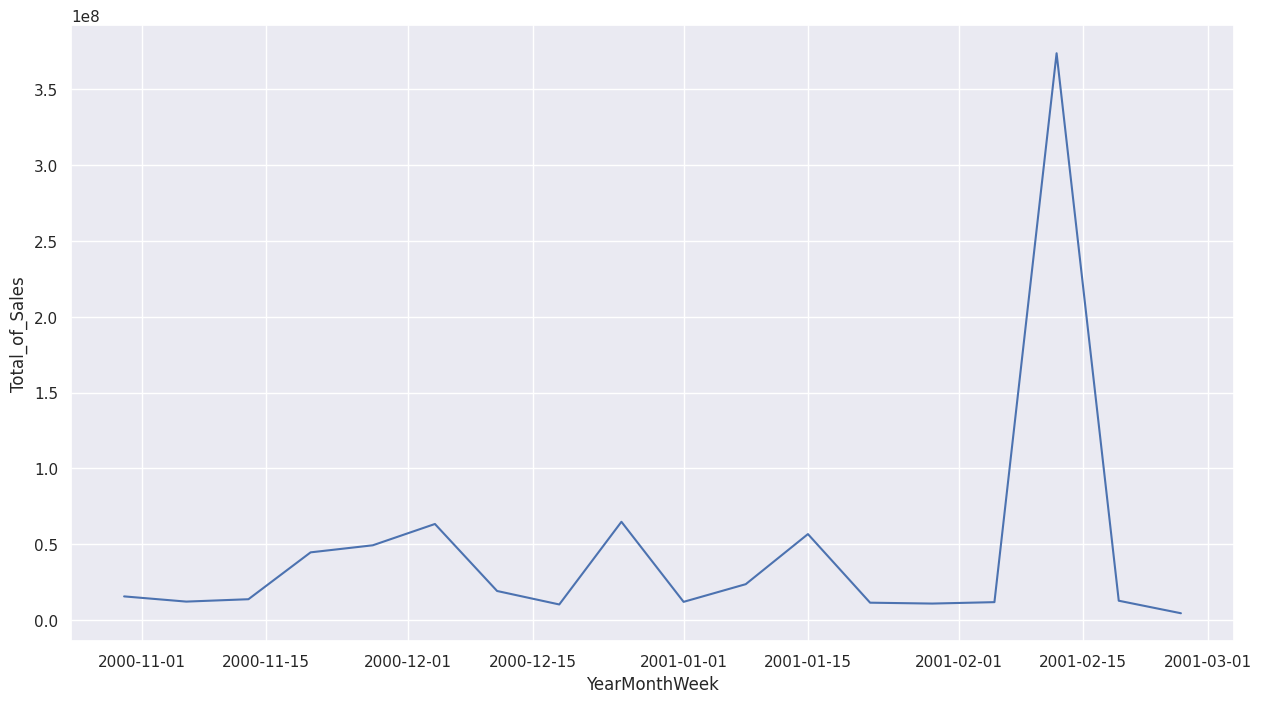

In [ ]:
# X軸：週の日付とY軸：総売上高

plt.figure(figsize=(15, 8))
sns.set(style="darkgrid")
sns.lineplot(x = 'YearMonthWeek', y = 'Total_of_Sales',data = df_weekly_output)

週次の総売上高を、折れ線グラフで見える化しています。
そうすると、圧倒的に2月の2週目に売り上げが急上昇していることがわかります。

これはチョコレートの売り上げデータでしょうか。ただ、実際のチョコレートのデータだと、バレンタインの数週前から売り上げ上がっているため、ここまで特異な上がり方をするのはおかしいですね。

もしかしたら、異常値データがこの期間に入っているのかもしれませんね。

In [ ]:
# 最後に曜日ごとの集計をしてみましょう

df_dayofweek_output = duckdb.query(
    f"""
    SELECT
    -- 曜日を出すために、EXTRACT関数を利用
    -- EXTRACT(date_part FROM date_expression)という文法で、こちらはBigQueryと同様
    -- https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions#date_trunc
    -- date_part : 'DAYOFWEEK' 日曜日（0）～土曜日（6）

    --  DATEPART('dow', CAST(Time AS DATE)) AS DayOfWeek,
      EXTRACT(DAYOFWEEK FROM CAST(Time AS DATE)) AS DayOfWeek,
      COUNT(DISTINCT CustID) AS Num_of_Purchaser,
      SUM(Amount) AS Total_of_Amount,
      SUM(Amount * SalesPrice) AS Total_of_Sales
    FROM df
    GROUP BY DayOfWeek
    ORDER BY DayOfWeek
    """
).to_df()

In [ ]:
 # データ確認
df_dayofweek_output.head(100)

,DayOfWeek,Num_of_Purchaser,Total_of_Amount,Total_of_Sales
0,0,14352,269449.0,62188145.0
1,1,10790,149428.0,106984397.0
2,2,9916,126317.0,46548467.0
3,3,9619,121606.0,88438791.0
4,4,9933,129479.0,59682062.0
5,5,9668,127408.0,33171837.0
6,6,12622,206252.0,415319109.0
